<a href="https://colab.research.google.com/github/Advanced-Data-Science-TU-Berlin/Data-Science-Training-Python-Part-2/blob/main/interactive_notebooks/1_1_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification
Text classification also known as text tagging or text categorization is the process of categorizing text into organized groups. By using Natural Language Processing (NLP), text classifiers can automatically analyze text and then assign a set of pre-defined tags or categories based on its content.

In this exercise we are using the data from one of the Kaggle competitions named “Toxic Comment Classification Challenge”. In this competition, we’re challenged to build a multi-headed model that’s capable of detecting different types of toxicity like threats, obscenity, insults, and identity-based hate. The dataset contains comments from Wikipedia’s talk page edits. (So, along with text classification we will also be learning how to implement multi-output/multi-label classification)

> The dataset for this competition contains text that may be considered profane, vulgar, or offensive. We do not encourage such words and this is only for experiment purposes.

Let's start with loading the data and look at its structure:



In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/julian3833/jigsaw-toxic-comment-classification-challenge", force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mahnaznmz
Your Kaggle Key: ··········


100%|██████████| 53.4M/53.4M [00:00<00:00, 59.9MB/s]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
% matplotlib inline

train_df = pd.read_csv("/content/jigsaw-toxic-comment-classification-challenge/train.csv")
test_df = pd.read_csv("/content/jigsaw-toxic-comment-classification-challenge/test.csv")
test_labels = pd.read_csv("/content/jigsaw-toxic-comment-classification-challenge/test_labels.csv")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Let's take a look at some statistics from the data:

In [ ]:
print("Train Size:\t", len(train_df))
print("Test Size:\t", len(test_df))
#Looking at the distribution of traget variables
display(train_df.iloc[:,2:].apply(pd.Series.value_counts, args = (True, True, False, None, False))) # value_counts args: [normalize, sort, ascending, bins, dropna]


Train Size:	 159571
Test Size:	 153164


,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.904156,0.990004,0.947052,0.997004,0.950636,0.991195
1,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805


As we can see we have a class imbalance in almost all the training target variables.

Here we also have multiple independent variables.

Let's split train dataset into training and validation sets:

In [ ]:
from sklearn.model_selection import train_test_split
#Dependent Variable
X = train_df.comment_text
#Independent Variables
y = train_df[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]]
#Splitting for checking the performance of the models on a holdout dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle = True, random_state = 123)

## Preprocessing
Preprocessing is one of the vital steps in NLP like any other ML task. In NLP, it helps to get rid of unhelpful parts of the data, or noise, by converting all characters to lowercase, removing punctuation marks, and removing stop words and typos. In this case, `punctuations` and `numbers` are removed along with `stopwords` like in, the, of so that these can be removed from texts as these words don't help in determining the classes (Whether a sentence is toxic or not)

> In this exercise we are also using NLTK which is a leading platform for building Python programs to work with human language data. To ream more check [here](https://www.nltk.org/).


Let's create a preprocessing function we can then pass it to our CountVectorizer model.

In [ ]:
from pandas.core.arrays.numeric import T
import nltk
import string
nltk.download('stopwords') # Download the stop-words
from nltk.corpus import stopwords

en_stopwords = set(stopwords.words('english')) # Getting stop-words for english
print("EN Stopwords:", en_stopwords)

#Function for basic cleaning/preprocessing texts
def clean(doc, stop_words=en_stopwords):
    # Removal of punctuation marks (.,/\][{} etc) and numbers
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    # Removal of stopwords
    doc = " ".join([token for token in doc.split() if token not in stop_words])
    return doc.lower()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
EN Stopwords: {'is', 'each', 'mightn', 'having', 'here', 'not', 'such', 'itself', 'his', 'under', 'own', "should've", 'other', 'my', 'those', 'more', 'shouldn', 'out', 'again', 'who', 'between', "shan't", 'isn', "she's", 'wouldn', 'shan', 'had', 'when', 'll', "mustn't", 'them', 'what', 'aren', 'don', 'me', "mightn't", 'she', 'doing', 'does', 'after', 'down', 'wasn', 't', 'which', 'where', 'we', 'himself', 'haven', 'too', 're', 'at', 'but', 'into', 'and', 'if', 'he', "weren't", 'd', 'nor', 'him', 'on', 'all', 'will', 'mustn', 'you', 'didn', "hasn't", "shouldn't", 'won', 'these', 's', 'just', 'yourselves', 'themselves', 'only', 'some', 'few', 'up', 'y', "it's", "couldn't", 'being', 'ourselves', 'yourself', 'the', 've', 'her', "needn't", 'whom', 'now', 'it', "wouldn't", 'was', 'while', "haven't", 'because', 'in', 'ours', "isn't", 'been', 'your', 'most', 'theirs', "you'll", 'this'

## Bag Of Words
Creating a bag of words model with a maximum of 5000 most-frequent words (as including all the words will make the dataset sparse and will only add noise).Also, Clean the dataset when creating the dataset using bag of words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features= 5000, preprocessor=clean)
X_train_dtm = vectorizer.fit_transform(X_train)
X_val_dtm = vectorizer.transform(X_val)

print(X_train_dtm.shape, X_val_dtm.shape)

(119678, 5000) (39893, 5000)


As we can see the same number of rows in train and validation datasets are 5000 columns which are essentially number of occurences of the 5000 most common words in each sentence.
Let's look at the 5 samples of bag of words vector:

In [ ]:
pd.DataFrame(X_train_dtm.A[:5], columns = vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abc,abide,ability,able,abortion,about,absence,absolute,absolutely,absurd,...,yourselfgo,youth,youtube,youve,ytmndin,yugoslavia,zealand,zero,zionist,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As we can see, in this vector whenever the word is present in the comment it will be >1 otherwise 0 (showing the number of occurance).

The Bag of words is pretty much sparse (we can further reduce the max_features if required). This will be the input for a Machine Learning Classifier.

## Multi-Output Classification
Since we need to classify each sentence as toxic or not, severe_toxic or not, obscene or not, threat or not, insult or not, and identity_hate or not, we need to classify the sentence against 6 output variables (This is called Multi-Label Classification which is different from multi-class classification where a target variable has more than 2 options e.g. a sentence can be positive, negative and neutral)

We will be using MultiOutputClassifier from sklearn which as mentioned earlier is a wrapper. This strategy consists of fitting one classifier per target.

### Logistic (Logit) Model
The logistic model (or logit model) is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick. This can be extended to model several classes of events such as determining whether an image contains a cat, dog, lion, etc. Each object being detected in the image would be assigned a probability between 0 and 1, with a sum of one.

<img src="https://www.saedsayad.com/images/LogReg_1.png">

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
#Initializing and fitting models on Training Data
#Naive Bayes Model
nb = MultiOutputClassifier(MultinomialNB()).fit(X_train_dtm, y_train)
#Logistic Regression Model (As we have unbalanced dataset, we use class_weight which will use inverse
#of counts of that class. It penalizes mistakes in samples of class[i] with class_weight[i] instead of 1)
lr = MultiOutputClassifier(LogisticRegression(class_weight='balanced', max_iter=3000)) \
                    .fit(X_train_dtm, y_train)

## Measuring Performance
### ROC - AUC
ROC (Receiver Operating Characteristic) Curve tells us about how good the model can distinguish between two things (e.g If a comment is toxic or not). Better models can accurately distinguish between the two. Whereas, a poor model will have difficulties in distinguishing between the two.

Let's see how does the ROC curves look like for the `toxic` label for both of our trained models:

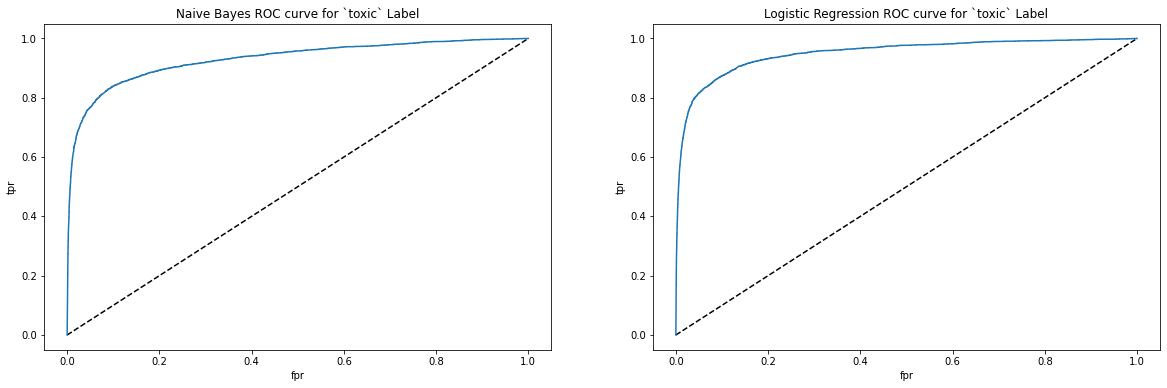

In [ ]:
from sklearn.metrics import roc_curve

# A helper function for plotting ROC curve for a model and a given label
def plot_roc_auc(model, model_name, label_name, ax):
  label_id = list(y_val.columns).index(label_name)
  y_vals = y_val[label_name].to_numpy()
  y_pred_proba = model.predict_proba(X_val_dtm)[label_id][:,1]
  fpr, tpr, thresholds = roc_curve(y_vals, y_pred_proba)
  # Plot ROC
  ax.plot([0,1],[0,1],'k--')
  ax.plot(fpr,tpr, label=model_name)
  ax.set_xlabel('fpr')
  ax.set_ylabel('tpr')
  ax.set_title(f'{model_name} ROC curve for `{label_name}` Label')

fig, ax = plt.subplots(1, 2, figsize=(20,6))
plot_roc_auc(nb, 'Naive Bayes', 'toxic', ax[0])
plot_roc_auc(lr, 'Logistic Regression', 'toxic', ax[1])


Let's compare the mean ROC-AUC across both models we have trained as the aggregated measurement of their performances. We will be using the predict_proba function of models instead of predict which gives us the probability scores instead of predicted value based on a threshold of 0.5, as it is used by the roc_auc_measure.

Let's write a function for calculating the roc_auc:

In [ ]:
from sklearn.metrics import roc_auc_score
#Function for calculating roc auc with given actual binary values across target variables and the probability score made by the model
def calculate_roc_auc(y_test, y_pred):
    aucs = []
    #Calculate the ROC-AUC for each of the target column
    for col in range(y_test.shape[1]):
        aucs.append(roc_auc_score(y_test[:,col],y_pred[:,col]))
    return aucs

Given the performance metrics let’s run the models on the validation dataset

In [ ]:
from statistics import mean
#Creating an empty list of results
results = []
#Making predictions from all the trained models and measure performance for each
for model in [nb,lr]:
    #Extracting name of the model
    est = type(model.estimator).__name__
    #Actual output variables
    y_vals = y_val.to_numpy()
    #Model Probabilities for class 1 of each of the target variables
    y_preds = np.transpose(np.array(model.predict_proba(X_val_dtm))[:,:,1])
    #Calculate Mean of the ROC-AUC
    mean_auc = mean(calculate_roc_auc(y_vals,y_preds))
    #Append the name of the model and the mean_roc_auc into the results list
    results.append([est, mean_auc])

#Output the results as a table
pd.DataFrame(results, columns = ["Model","Mean AUC"])

,Model,Mean AUC
0,MultinomialNB,0.935594
1,LogisticRegression,0.936710


As we can see, Both the models perform really good with LR performing slightly better. So, we will use it as the final model to submit the predictions for the test data. Also, these simple models give pretty good results without much of a hassle or technical know-how, that is why they are still used widely.

## Predicting Target Values for Test Data
test_df

In [ ]:
#Transform the test dataset as well based on Bag of Words/ Count Vectorizer as the Logistic model would
X_test_dtm = vectorizer.transform(test_df['comment_text'])
#Use the Logistic Regression model to output probabilities and take the probability for class 1
y_preds = np.transpose(np.array(lr.predict_proba(X_test_dtm))[:,:,1])
#Add predicted labels to the test data
test_pred_labels = test_df.assign(**pd.DataFrame(y_preds, columns=train_df.iloc[:,2:].columns))
#Calculate avg roc_auc on test data
print("Mean AUC on Test:", mean(calculate_roc_auc(test_labels.iloc[:,1:].replace(-1, 0).to_numpy(), y_preds)))

Mean AUC on Test: 0.9020280915716352


As we can see we are still having a rather good performance on unseen data ~90%

## Model Interpretation
This is the most exciting part. Since, we are just using a simple Logistic Regression model, we can directly use the coefficient values of the model to get an understanding of the predictions made. By doing so, which feature is importance or which word makes a sentence toxic. If we would use a complex model, we could go for SHAP or LIME. Also, since we have 6 output variables, we will have 6 feature importances which will be interesting to see

In [ ]:
#Assigning the feature names to an empty list
feat_impts = [vectorizer.get_feature_names()]
#For all the models save the feature importances in the list.estimators_ would give the internal models used by the multioutput regressor
for clf in lr.estimators_:
    feat_impts.append(clf.coef_.flatten())
#Saving the results in a dataframe
df_feats_impts = pd.DataFrame(np.transpose(np.array(feat_impts)), columns = ["word","toxic","severe_toxic","obscene","threat","insult","identity_hate"])
#Converting Feature Importance Columns from string to float
df_feats_impts.iloc[:,1:] = df_feats_impts.iloc[:,1:].astype("float32")
df_feats_impts.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,word,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,abc,-1.054371,-0.33688,-0.79903,-1.293537,0.124339,-0.812871
1,abide,-0.562431,-0.024591,0.284508,-0.174758,-0.325062,-0.144911
2,ability,0.422333,-0.318053,-0.160442,-0.363774,-0.347794,-0.645233
3,able,-0.43884,-0.241395,0.148765,-1.463267,-0.859282,-0.789607
4,abortion,-1.271754,-0.054597,0.592756,-0.012501,0.531256,0.692981


We will look at Top 5 words which determine if the sentence is a toxic-type or not according to the model.

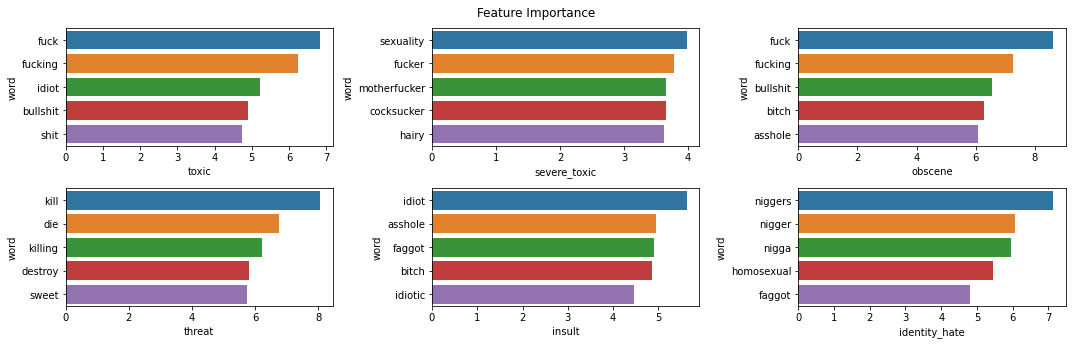

In [ ]:
#Creating Individual Feature Importance table by sorting on specific toxic-type column and selecting top 5 words
toxic_fi = df_feats_impts[["word","toxic"]].sort_values(by = "toxic", ascending = False).head()
severe_toxic_fi = df_feats_impts[["word","severe_toxic"]].sort_values(by = "severe_toxic", ascending = False).head()
obscene_fi = df_feats_impts[["word","obscene"]].sort_values(by = "obscene", ascending = False).head()
threat_fi = df_feats_impts[["word","threat"]].sort_values(by = "threat", ascending = False).head()
insult_fi = df_feats_impts[["word","insult"]].sort_values(by = "insult", ascending = False).head()
identity_hate_fi = df_feats_impts[["word","identity_hate"]].sort_values(by = "identity_hate", ascending = False).head()

#Plotting top 5 words based on coefficient values from the LR model
fig,(ax1, ax2) =  plt.subplots(2,3,figsize=(15,5))
sns.barplot(x = "toxic", y = "word", ax = ax1[0], data = toxic_fi)
sns.barplot(x = "severe_toxic", y = "word", ax = ax1[1], data = severe_toxic_fi)
sns.barplot(x = "obscene", y = "word", ax = ax1[2], data = obscene_fi)
sns.barplot(x = "threat", y = "word", ax = ax2[0], data = threat_fi)
sns.barplot(x = "insult", y = "word", ax = ax2[1], data = insult_fi)
sns.barplot(x = "identity_hate", y = "word", ax = ax2[2], data = identity_hate_fi)
plt.suptitle("Feature Importance")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We can see that the models are quite rightly selecting the most important features and it makes complete sense

For e.g. for threats - words like kill, shoot, destroy etc are most important

for identity hate - words like nigger, nigga, homosexual, faggot

most important words for toxic are less extreme than most important words for severe toxic.

## TODOs:
1. Try TF-IDF instead of CountVectorizer
TF-IDF tend to perform better than CountVectorizer in some cases
2. Try ensemble models instead of Vanilla ML models
Bagging and Boosting models give better results than classic ML techniques in most cases
3. Better Text Preprocessing
Typo correction, Lemmatization, etc can be done to further improve the model

Useful Links:
- https://medium.com/analytics-vidhya/text-classification-from-bag-of-words-to-bert-1e628a2dd4c9
- https://towardsdatascience.com/text-classification-using-naive-bayes-theory-a-working-example-2ef4b7eb7d5a#:~:text=1.-,Introduction,is%20independent%20of%20each%20other